In [ ]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# change working directory
import os
from pathlib import Path

os.chdir(Path().resolve().parent)

Now working in: /Users/gavinbarro/Documents/VT_programming/Fall_2025/CS-5805-Machine-Learning/CinemaSuccessSage


In [10]:
# load data

# TMBD
tmdb = pd.read_csv('data/raw/TMDB_movie_dataset_v11.csv', low_memory=False)


# TheMoviesDataset
tm_metadata = pd.read_csv('data/raw/TheMoviesDataset/movies_metadata.csv', low_memory=False)
tm_credits = pd.read_csv('data/raw/TheMoviesDataset/credits.csv')
tm_keywords = pd.read_csv('data/raw/TheMoviesDataset/keywords.csv')
tm_links = pd.read_csv('data/raw/TheMoviesDataset/links.csv')
tm_ratings = pd.read_csv('data/raw/TheMoviesDataset/ratings.csv')


# MovieLens 
ml_movies = pd.read_csv('data/raw/MovieLens/movie.csv')
ml_links = pd.read_csv('data/raw/MovieLens/link.csv')
ml_ratings = pd.read_csv('data/raw/MovieLens/rating.csv')



In [38]:
#  inspection function


def inspect_df(df: pd.DataFrame, name: str) -> None:
    """
        Perform a quick exploratory inspection of a pandas DataFrame and print key information

        This utility function displays the most useful details when working on
        getting familiar with a new dataset or debugging data loading and/or cleaning steps

        Args:
            df: pd.DataFrame
                The DataFrame to inspect
            name: str
                A descriptive name for the DataFrame ("TMDB movies", "credits", "ratings")
                Appears in the header for easier identification when inspecting multiple datasets

        Returns:
            None
    """
    
    print(f"\n=== Inspection for {name} ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Data Types:\n{df.dtypes}")
    print(f"Missing Values (%):\n{(df.isnull().mean() * 100).round(2)}")
    print(f"Sample Rows:\n{df.head(3)}")  # First 3 rows

In [12]:
# Inspect main ones
inspect_df(tmdb, "TMDB_movie_dataset_v11.csv")
inspect_df(tm_metadata, "TheMoviesDataset - movies_metadata.csv")
inspect_df(tm_credits, "TheMoviesDataset - credits.csv")
inspect_df(tm_keywords, "TheMoviesDataset - keywords.csv")
inspect_df(tm_links, "TheMoviesDataset - links.csv")
inspect_df(tm_ratings, "TheMoviesDataset - ratings.csv")
inspect_df(ml_movies, "MovieLens - movie.csv")
inspect_df(ml_links, "MovieLens - link.csv")
inspect_df(ml_ratings, "MovieLens - rating.csv")


=== Inspection for TMDB_movie_dataset_v11.csv ===
Shape: (1329370, 24)
Columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']
Data Types:
id                        int64
title                    object
vote_average            float64
vote_count                int64
status                   object
release_date             object
revenue                   int64
runtime                   int64
adult                      bool
backdrop_path            object
budget                    int64
homepage                 object
imdb_id                  object
original_language        object
original_title           object
overview                 object
popularity              float64
poster_path              obje

In [32]:
# Clean and standardize
tm_metadata['id'] = pd.to_numeric(tm_metadata['id'], errors='coerce')
tm_metadata['budget'] = pd.to_numeric(tm_metadata['budget'], errors='coerce')
tm_metadata['revenue'] = pd.to_numeric(tm_metadata['revenue'], errors='coerce')  # Ensure numeric
tm_links['tmdbId'] = pd.to_numeric(tm_links['tmdbId'], errors='coerce')
tmdb['id'] = pd.to_numeric(tmdb['id'], errors='coerce')

In [33]:
# Step 1: Aggregate average user ratings from TheMoviesDataset
avg_user_ratings = tm_ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
avg_user_ratings.rename(columns={'mean': 'avg_user_rating', 'count': 'user_rating_count'}, inplace=True)

# Merge with links to get TMDB ID
avg_user_ratings = avg_user_ratings.merge(tm_links[['movieId', 'tmdbId']], on='movieId', how='left')
avg_user_ratings = avg_user_ratings.dropna(subset=['tmdbId'])
avg_user_ratings['tmdbId'] = avg_user_ratings['tmdbId'].astype(int)

In [34]:
# Step 2: Base from TMDB
merged_df = tmdb.copy()

# Merge average user ratings
merged_df = merged_df.merge(avg_user_ratings[['tmdbId', 'avg_user_rating', 'user_rating_count']], left_on='id', right_on='tmdbId', how='left')
merged_df.drop(columns=['tmdbId'], inplace=True)

# Step 3: Merge TheMovies metadata (adds details like belongs_to_collection)
merged_df = merged_df.merge(tm_metadata, on='id', how='left', suffixes=('_tmdb', '_tm'))

# Step 4: Merge credits and keywords
merged_df = merged_df.merge(tm_credits, on='id', how='left')
merged_df = merged_df.merge(tm_keywords, on='id', how='left')

In [39]:
# Step 5: Handle duplicates/redundants
merged_df.drop_duplicates(subset=['id'], keep='first', inplace=True)

# Drop _tm suffixed columns where TMDB has equivalent (customize after inspect)
redundant_cols = [col for col in merged_df.columns if '_tm' in col and col.replace('_tm', '_tmdb') in merged_df.columns]
merged_df.drop(columns=redundant_cols, inplace=True, errors='ignore')

# Print columns before filtering
print("Columns before filtering:", merged_df.columns.tolist())

# Handle keywords conflict: Prefer TMDB's (keywords_x), drop _y, rename
if 'keywords_x' in merged_df.columns and 'keywords_y' in merged_df.columns:
    merged_df.drop(columns=['keywords_y'], inplace=True)
    merged_df.rename(columns={'keywords_x': 'keywords'}, inplace=True)

# Fill NaNs in count columns before filtering (to treat missing ratings as 0)
merged_df['user_rating_count'] = merged_df['user_rating_count'].fillna(0)
merged_df['vote_count_tmdb'] = merged_df['vote_count_tmdb'].fillna(0)

# Step 6: Filter for quality (focus on movies with data for both targets)
merged_df = merged_df[(merged_df['revenue_tmdb'] > 0) & (merged_df['budget_tmdb'] > 0) & 
                      (merged_df['vote_count_tmdb'] > 10) & (merged_df['user_rating_count'] > 50).fillna(0)]  # Fill count NaNs

# Save as Parquet for efficiency
merged_df.to_parquet('data/processed/merged_movies.parquet', index=False)
print(f"Merged DF Shape: {merged_df.shape}")
inspect_df(merged_df, "Merged Dataset")  # Reuse the above inspection function

Columns before filtering: ['id', 'title_tmdb', 'vote_average_tmdb', 'vote_count_tmdb', 'status_tmdb', 'release_date_tmdb', 'revenue_tmdb', 'runtime_tmdb', 'adult_tmdb', 'backdrop_path', 'budget_tmdb', 'homepage_tmdb', 'imdb_id_tmdb', 'original_language_tmdb', 'original_title_tmdb', 'overview_tmdb', 'popularity_tmdb', 'poster_path_tmdb', 'tagline_tmdb', 'genres_tmdb', 'production_companies_tmdb', 'production_countries_tmdb', 'spoken_languages_tmdb', 'keywords', 'avg_user_rating', 'user_rating_count', 'belongs_to_collection', 'video', 'cast', 'crew']
Merged DF Shape: (5950, 30)

=== Inspection for Merged Dataset ===
Shape: (5950, 30)
Columns: ['id', 'title_tmdb', 'vote_average_tmdb', 'vote_count_tmdb', 'status_tmdb', 'release_date_tmdb', 'revenue_tmdb', 'runtime_tmdb', 'adult_tmdb', 'backdrop_path', 'budget_tmdb', 'homepage_tmdb', 'imdb_id_tmdb', 'original_language_tmdb', 'original_title_tmdb', 'overview_tmdb', 'popularity_tmdb', 'poster_path_tmdb', 'tagline_tmdb', 'genres_tmdb', 'produc

In [36]:
# Load merged data
merged_df = pd.read_parquet('data/processed/merged_movies.parquet')

# Summary Statistics
print("=== Summary Statistics ===")
print(merged_df.describe())  # Numerical columns: means, mins, maxes, etc.
print("\nCategorical Summary:")
print(merged_df['genres_tmdb'].value_counts().head(10))  # Top genres
print(merged_df['original_language_tmdb'].value_counts().head(5))  # Top languages

# Handle outliers (example: cap extreme revenue/budget at 99th percentile)
percentile_99 = merged_df['revenue_tmdb'].quantile(0.99)
merged_df['revenue_tmdb'] = merged_df['revenue_tmdb'].clip(upper=percentile_99)

# Repeat for budget_tmdb
percentile_99_budget = merged_df['budget_tmdb'].quantile(0.99)
merged_df['budget_tmdb'] = merged_df['budget_tmdb'].clip(upper=percentile_99_budget)

=== Summary Statistics ===
                  id  vote_average_tmdb  vote_count_tmdb  revenue_tmdb  \
count    5950.000000        5950.000000      5950.000000  5.950000e+03   
mean    43840.037647           6.487688      2136.047899  8.696184e+07   
std     77294.560440           0.806298      3397.795775  1.617844e+08   
min         5.000000           2.661000        13.000000  1.000000e+00   
25%      8195.500000           5.982000       316.000000  8.102290e+06   
50%     12150.500000           6.501000       898.000000  2.995888e+07   
75%     37397.250000           7.053000      2358.000000  9.391261e+07   
max    419430.000000           8.707000     34495.000000  2.923706e+09   

       runtime_tmdb   budget_tmdb  popularity_tmdb  avg_user_rating  \
count   5950.000000  5.950000e+03      5950.000000      5950.000000   
mean     108.882521  3.013203e+07        20.532582         3.223539   
std       20.483929  3.872518e+07        15.521988         0.499715   
min        5.000000  3

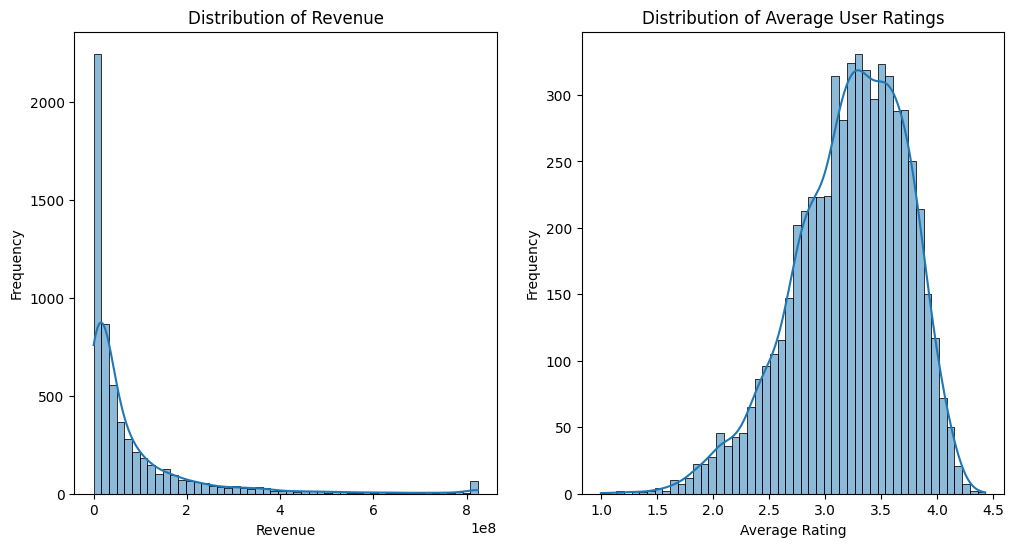

In [37]:
# Visualizations
plt.figure(figsize=(12, 6))

# Distribution of Targets
plt.subplot(1, 2, 1)
sns.histplot(merged_df['revenue_tmdb'], bins=50, kde=True)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.savefig('reports/figures/eda/revenue_distribution.png')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['avg_user_rating'], bins=50, kde=True)
plt.title('Distribution of Average User Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.savefig('reports/figures/eda/ratings_distribution.png')
plt.show()

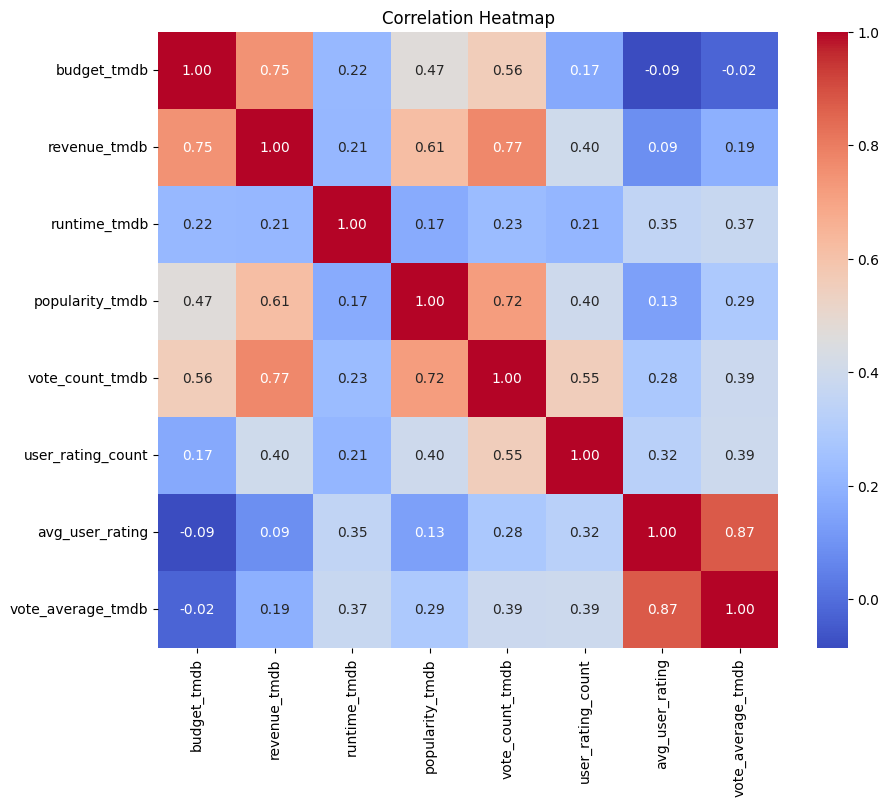

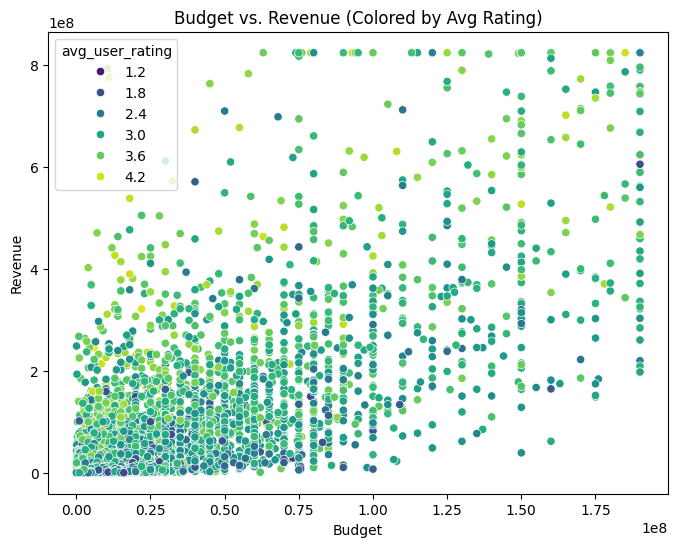

In [27]:
# Correlations (numerical features)
num_cols = ['budget_tmdb', 'revenue_tmdb', 'runtime_tmdb', 'popularity_tmdb', 'vote_count_tmdb', 'user_rating_count', 'avg_user_rating', 'vote_average_tmdb']
corr_matrix = merged_df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('reports/figures/eda/correlation_heatmap.png')
plt.show()

# Scatter Plot: Budget vs. Revenue
plt.figure(figsize=(8, 6))
sns.scatterplot(x='budget_tmdb', y='revenue_tmdb', data=merged_df, hue='avg_user_rating', palette='viridis')
plt.title('Budget vs. Revenue (Colored by Avg Rating)')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.savefig('reports/figures/eda/budget_vs_revenue_scatter.png')
plt.show()

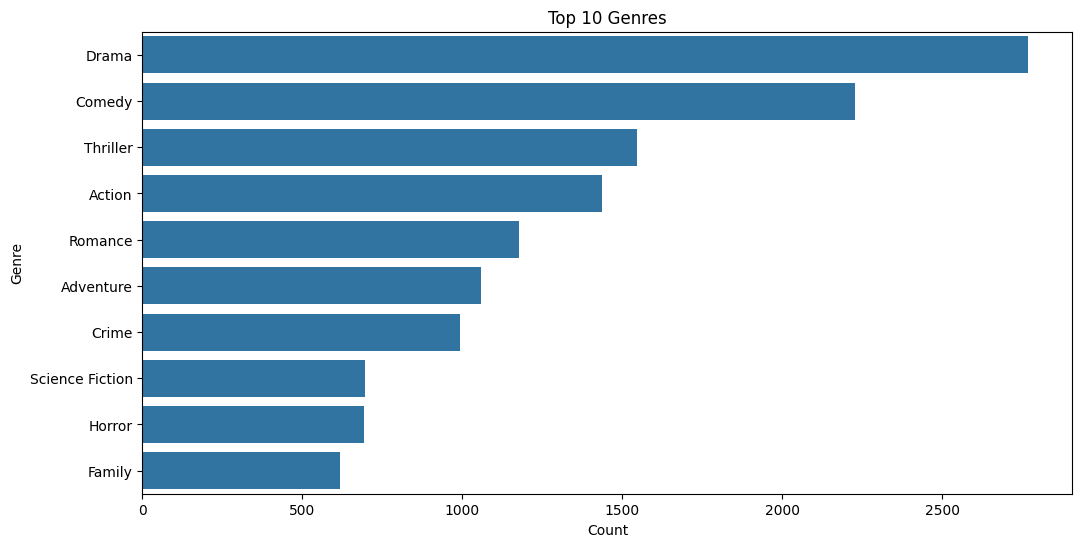

In [30]:
# Genre Counts (basic parsing; full one hot in feature engineering)
# Extract top genres
merged_df['genres_list'] = merged_df['genres_tmdb'].str.split(', ')
genres_exploded = merged_df.explode('genres_list').reset_index(drop=True)
plt.figure(figsize=(12, 6))
sns.countplot(y='genres_list', data=genres_exploded, order=genres_exploded['genres_list'].value_counts().index[:10])
plt.title('Top 10 Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.savefig('reports/figures/top_genres_bar.png')
plt.show()